In [1]:
# Import libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import generate_quantum_dataset as gqd

In [2]:
# Import datasets

sep_data = th.load('../datasets/sep_states1.pt')

ent_data = th.load('../datasets/ent_states1.pt')

sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim=1)
ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim=1)

sep_data_pair.shape, ent_data_pair.shape

(torch.Size([30000, 2, 81]), torch.Size([30000, 2, 81]))

In [3]:
sep_loader = DataLoader(sep_data, batch_size=64, shuffle=True)
ent_loader = DataLoader(ent_data, batch_size=64, shuffle=True)

In [4]:
# Split the data into training and testing sets

sep_train, sep_test = train_test_split(sep_data_pair, test_size=0.3)
ent_train, ent_test = train_test_split(ent_data_pair, test_size=0.3)

sep_train.shape, sep_test.shape, ent_train.shape, ent_test.shape

(torch.Size([21000, 2, 81]),
 torch.Size([9000, 2, 81]),
 torch.Size([21000, 2, 81]),
 torch.Size([9000, 2, 81]))

In [5]:
BATCH_SIZE = 64
ent_train_loader = DataLoader(ent_train, batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(ent_test, batch_size=BATCH_SIZE, shuffle=True)
sep_train_loader = DataLoader(sep_train, batch_size=BATCH_SIZE, shuffle=True)
sep_test_loader = DataLoader(sep_test, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class VAE_fc(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VAE_fc, self).__init__()
        self.enc1 = nn.Linear(input_size, hidden_size[0])
        self.enc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.enc_mu = nn.Linear(hidden_size[1], hidden_size[2])
        self.enc_logvar = nn.Linear(hidden_size[1], hidden_size[2])
        
        self.dec1 = nn.Linear(hidden_size[2], hidden_size[1])
        self.dec2 = nn.Linear(hidden_size[1], hidden_size[0])
        self.dec3 = nn.Linear(hidden_size[0], input_size)
    
    def encoder(self, x):
        
        # print("flatten", x.shape)
        x = nn.ReLU()(self.enc1(x))
        x = nn.ReLU()(self.enc2(x))
        
        mu = nn.ReLU()(self.enc_mu(x))
        logvar = nn.ReLU()(self.enc_logvar(x))
        
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = th.exp(0.5 * logvar)
        eps = th.randn_like(std)
        return mu + eps * std 
        
    
    def decoder(self, z):
        z = nn.ReLU()(self.dec1(z))
        z = nn.ReLU()(self.dec2(z))
        z = th.sigmoid(self.dec3(z))
        return z
    
    
    def forward(self, x):
        # print("input", x.shape)
        # x = x.flatten(start_dim=1)
        # print("flatten", x.shape)
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, z, mu, logvar
    
# model = VAE_fc(input_size=4, hidden_size=[10, 5, 2])

# for _, data in enumerate(sep_train_loader):
#     print(data.shape)
#     output = model(data)
#     print(output[0].shape)
#     break

In [21]:
# Define the training function
def train_model(model, train_loader, epochs, optimizer, criterion, device):
    trained_model = model.to(device)
    trained_model.train()
    train_loss = []
    for epoch in range(epochs):
        batch_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            decoded, z, mu, logvar = trained_model(data)
            loss = criterion(data, decoded, mu, logvar)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        batch_loss /= len(train_loader)
        train_loss.append(batch_loss)
        
        print(f'Epoch: {epoch + 1}, Loss: {batch_loss:.4f}')
    return trained_model, np.array(train_loss)

def get_test_loss(trained_model, test_loader, criterion):
    trained_model.eval()
    decoded_data = []
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        decoded, z, mu, logvar = trained_model(data)
        decoded_data.append(decoded.detach().numpy())
        test_loss += criterion(data, decoded).item()
    test_loss /= len(test_loader)
    return test_loss, np.array(decoded_data)

def get_test_loss_KL(trained_model, test_loader, criterion):
    trained_model.eval()
    decoded_data = []
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        decoded, z, mu, logvar = trained_model(data)
        decoded_data.append(decoded.detach().numpy())
        test_loss += criterion(data, decoded, mu, logvar).item()
    test_loss /= len(test_loader)
    return test_loss, np.array(decoded_data)

In [22]:
def VAE_loss(input, output, mu, logvar):
    reconstruction_loss = F.mse_loss(output, input, reduction='sum')
    KL_loss = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(reconstruction_loss.item(), KL_loss.item())
    return reconstruction_loss + 0.5 * KL_loss

# Define the loss function

def custom_loss(input, output, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(output, input, reduction='sum')
    KL_div = -0.5 * th.sum(1 + logvar - mean * mean - logvar.exp())
    
    return reproduction_loss + KL_div

In [23]:
EPOCHS = 15
HIDDEN_SIZE = [100, 50, 20]
LEARNING_RATE = 0.001
INPUT_SIZE = 81

model = VAE_fc(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
optimizer = th.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

trained_model_ent, train_loss_ent = train_model(model = model,
                                                train_loader = ent_train_loader,
                                                epochs = EPOCHS,
                                                optimizer = optimizer,
                                                criterion = VAE_loss,
                                                device = 'cpu')

Epoch: 1, Loss: 30.1819
Epoch: 2, Loss: 0.5263
Epoch: 3, Loss: 0.5185
Epoch: 4, Loss: 0.4951
Epoch: 5, Loss: 0.4585
Epoch: 6, Loss: 0.4350
Epoch: 7, Loss: 0.4287
Epoch: 8, Loss: 0.4255
Epoch: 9, Loss: 0.4242
Epoch: 10, Loss: 0.4234
Epoch: 11, Loss: 0.4226
Epoch: 12, Loss: 0.4226
Epoch: 13, Loss: 0.4222
Epoch: 14, Loss: 0.4217
Epoch: 15, Loss: 0.4216


In [24]:
train_loss_ent_model = []
trained_model_ent.eval()
train_loss_ent_model.append(get_test_loss(trained_model_ent, ent_train_loader, F.mse_loss)[0])
train_loss_ent_model.append(get_test_loss_KL(trained_model_ent, ent_train_loader, VAE_loss)[0])

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)
/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


In [25]:
test_loss_func = F.mse_loss
test_loss_ent_model_ent_data = []
test_loss_ent_model_ent_data.append(get_test_loss(trained_model_ent.eval(), ent_test_loader, test_loss_func)[0])
test_loss_ent_model_ent_data.append(get_test_loss_KL(trained_model_ent.eval(), ent_test_loader, VAE_loss)[0])

test_loss_ent_model_sep_data = []
test_loss_ent_model_sep_data.append(get_test_loss(trained_model_ent.eval(), sep_test_loader, test_loss_func)[0])
test_loss_ent_model_sep_data.append(get_test_loss_KL(trained_model_ent.eval(), sep_test_loader, VAE_loss)[0])

test_loss_ent_model_ent_data, test_loss_ent_model_sep_data

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)
/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


([4.095440444935704e-05, 0.42342007963369926],
 [1.440836181019925e-05, 0.14864306490049295])

In [26]:
model = VAE_fc(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
optimizer = th.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

trained_model_sep, train_loss_sep = train_model(model = model,
                                                train_loader = sep_train_loader,
                                                epochs = EPOCHS,
                                                optimizer = optimizer,
                                                criterion = VAE_loss,
                                                device = 'cpu')

Epoch: 1, Loss: 31.1021
Epoch: 2, Loss: 0.1293
Epoch: 3, Loss: 0.1234
Epoch: 4, Loss: 0.1204
Epoch: 5, Loss: 0.1132
Epoch: 6, Loss: 0.1039
Epoch: 7, Loss: 0.0990
Epoch: 8, Loss: 0.0976
Epoch: 9, Loss: 0.0971
Epoch: 10, Loss: 0.0967
Epoch: 11, Loss: 0.0966
Epoch: 12, Loss: 0.0964
Epoch: 13, Loss: 0.0965
Epoch: 14, Loss: 0.0965
Epoch: 15, Loss: 0.0963


In [27]:
train_loss_sep_model = []
trained_model_sep.eval()
train_loss_sep_model.append(get_test_loss(trained_model_sep, sep_train_loader, F.mse_loss)[0])
train_loss_sep_model.append(get_test_loss_KL(trained_model_sep, sep_train_loader, VAE_loss)[0])

train_loss_sep_model

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)
/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


[9.271809539946888e-06, 0.09590584064881943]

In [28]:
test_loss_sep_model_ent_data = []
test_loss_sep_model_ent_data.append(get_test_loss(trained_model_sep, ent_test_loader, test_loss_func)[0])
test_loss_sep_model_ent_data.append(get_test_loss_KL(trained_model_sep, ent_test_loader, VAE_loss)[0])

test_loss_sep_model_sep_data = []
test_loss_sep_model_sep_data.append(get_test_loss(trained_model_sep, sep_test_loader, test_loss_func)[0])
test_loss_sep_model_sep_data.append(get_test_loss_KL(trained_model_sep, sep_test_loader, VAE_loss)[0])

test_loss_sep_model_ent_data, test_loss_sep_model_sep_data

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)
/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_22073/451731354.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


([4.54910159726538e-05, 0.47020065974681935],
 [9.259664306653654e-06, 0.09576186368651424])

In [29]:
print(test_loss_ent_model_ent_data, test_loss_ent_model_sep_data)
print(test_loss_sep_model_ent_data, test_loss_sep_model_sep_data)

[4.095440444935704e-05, 0.42342007963369926] [1.440836181019925e-05, 0.14864306490049295]
[4.54910159726538e-05, 0.47020065974681935] [9.259664306653654e-06, 0.09576186368651424]


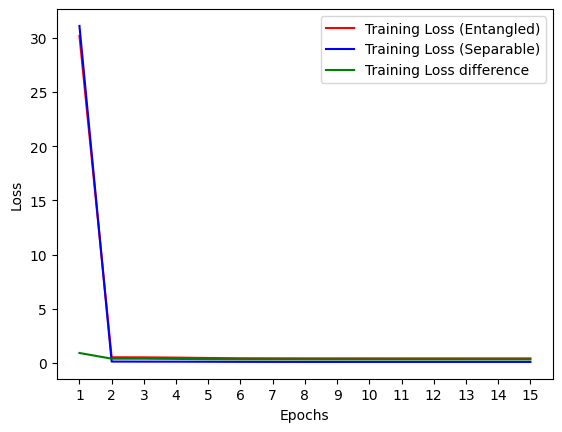

In [68]:
x_values = np.arange(1, len(train_loss_ent) + 1)
x_ticks = x_values

plt.plot(x_values, train_loss_ent, label='Training Loss (Entangled)', color='red')
plt.plot(x_values, train_loss_sep, label='Training Loss (Separable)', color = 'blue')
plt.plot(x_values, np.abs(train_loss_ent - train_loss_sep), label = 'Training Loss difference', color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(x_ticks)
plt.legend()

plt.savefig('VAE_fc_train_loss.png')

In [42]:
train_loss_ent

array([30.18191439,  0.52626084,  0.51846344,  0.49507511,  0.45847638,
        0.43496487,  0.42872175,  0.42551543,  0.42424234,  0.42338675,
        0.42255839,  0.42256207,  0.42224823,  0.42172124,  0.42161201])

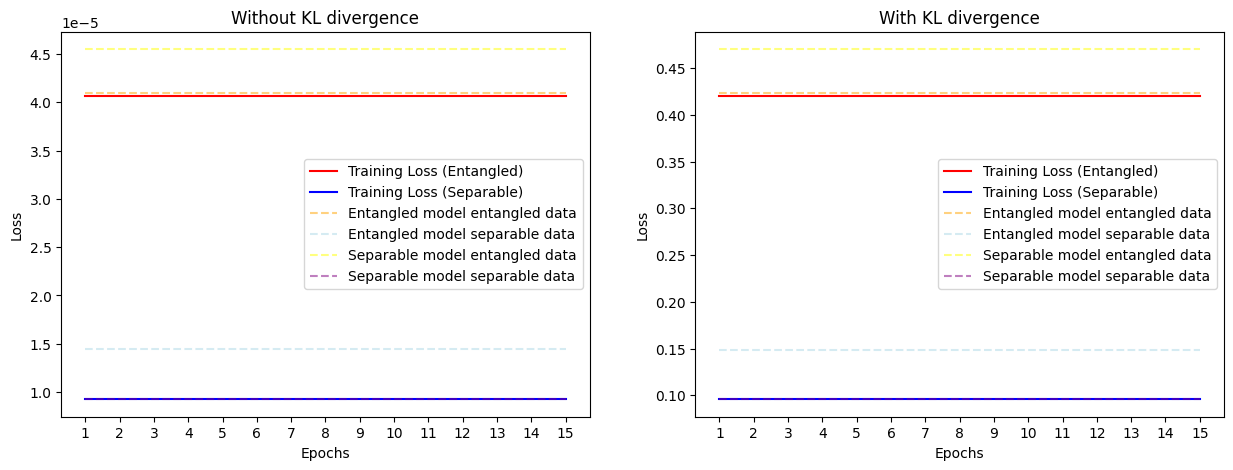

In [53]:
# Losses without KL divergence
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
titles = ['Without KL divergence', 'With KL divergence']

for i in range(2):
    ax[i].plot(x_values, train_loss_ent_model[i] * np.ones(len(x_values)), label='Training Loss (Entangled)', color = 'red')
    ax[i].plot(x_values, train_loss_sep_model[i]* np.ones(len(x_values)), label='Training Loss (Separable)', color = 'blue')
    ax[i].plot(x_values, test_loss_ent_model_ent_data[i] * np.ones(len(x_values)), label='Entangled model entangled data', alpha=0.5, linestyle='--', color = 'orange')
    ax[i].plot(x_values, test_loss_ent_model_sep_data[i] * np.ones(len(x_values)), label='Entangled model separable data', alpha=0.5, linestyle='--', color = 'lightblue')
    ax[i].plot(x_values, test_loss_sep_model_ent_data[i] * np.ones(len(x_values)), label='Separable model entangled data', alpha=0.5, linestyle='--', color = 'yellow')
    ax[i].plot(x_values, test_loss_sep_model_sep_data[i] * np.ones(len(x_values)), label='Separable model separable data', alpha=0.5, linestyle='--', color = 'purple')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].set_title(titles[i])
    # ax[i].xlabel('Epochs')
    # ax[i].ylabel('Loss')
    ax[i].set_xticks(x_ticks)
    ax[i].legend()

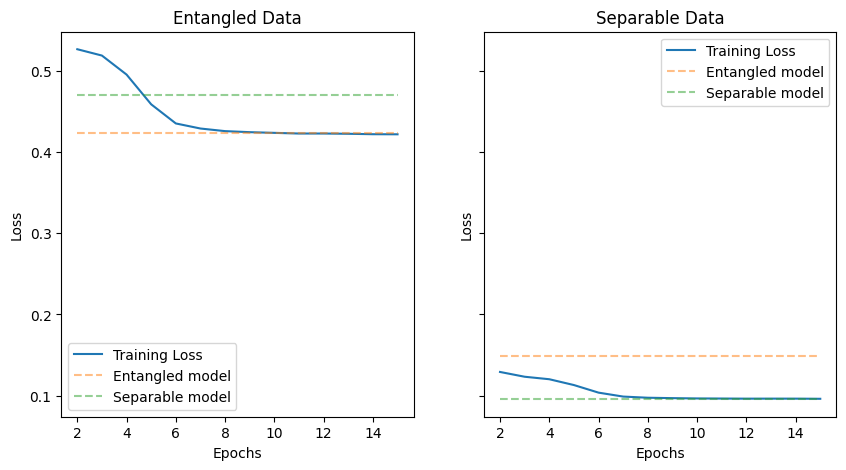

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
x_values = np.arange(2, len(train_loss_ent) + 1)

axs[0].plot(x_values, train_loss_ent[1:], label='Training Loss')
# axs[0].plot(x_values, train_loss_ent_model[1] * np.ones(len(x_values)), label='Training Loss')
axs[0].plot(x_values, test_loss_ent_model_ent_data[1] * np.ones(len(x_values)), label='Entangled model', alpha=0.5, linestyle='--')
axs[0].plot(x_values, test_loss_sep_model_ent_data[1] * np.ones(len(x_values)), label='Separable model', alpha=0.5, linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Entangled Data')
axs[0].legend()
axs[0].set_ylabel('Loss')

axs[1].plot(x_values, train_loss_sep[1:], label='Training Loss')
# axs[1].plot(x_values, train_loss_sep_model[1] * np.ones(len(x_values)), label='Training Loss')
axs[1].plot(x_values, test_loss_ent_model_sep_data[1] * np.ones(len(x_values)), label='Entangled model', alpha=0.5, linestyle='--')
axs[1].plot(x_values, test_loss_sep_model_sep_data[1] * np.ones(len(x_values)), label='Separable model', alpha=0.5, linestyle='--')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Separable Data')
axs[1].legend()
axs[1].set_ylabel('Loss')


plt.savefig('../Figures/VAE_loss.png')